### Env Config

In [1]:
CLASSIFICACAO_DF = 'PF' # PJ ou PF

In [2]:
%%capture
%pip install pandas matplotlib numpy

In [46]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
ORDEM_PORTE = [
    "Indisponível",
    "Sem rendimento",
    "Micro",
    "Pequeno",
    "Médio",
    "Grande",
    "Até 1 salário mínimo",
    "Mais de 1 a 2 salários mínimos",
    "Mais de 2 a 3 salários mínimos",
    "Mais de 3 a 5 salários mínimos",
    "Mais de 5 a 10 salários mínimos",
    "Mais de 10 a 20 salários mínimos",
    "Acima de 20 salários mínimos"
]

In [5]:
df = pd.read_parquet('data/operacoes_credito.parquet')
df = df[df['ct_classificacao'] == CLASSIFICACAO_DF]

In [6]:
inflacao_df = pd.read_csv('data/taxas_inflacao.csv')

In [7]:
selic_df = pd.read_csv('data/taxas_selic.csv')

In [8]:
# Dados de https://brasilescola.uol.com.br/brasil/pib-dos-estados-brasileiros.htm#PIB+do+Brasil
pib_df = pd.DataFrame([
	{ 'estado': 'Norte', 'pib': 478_173_000_000 },
	{ 'estado': 'Nordeste', 'pib': 1_079_331_000_000 },
	{ 'estado': 'Centro-Oeste', 'pib': 791_251_000_000 },
	{ 'estado': 'Sudeste', 'pib': 3_952_695_000_000 },
	{ 'estado': 'Sul', 'pib': 1_308_148_000_000 },
])

In [9]:
estados_df = pd.DataFrame([
	{ 'estado': 'AC', 'regiao': 'Norte' },
	{ 'estado': 'AL', 'regiao': 'Nordeste' },
	{ 'estado': 'AP', 'regiao': 'Norte' },
	{ 'estado': 'AM', 'regiao': 'Norte' },
	{ 'estado': 'BA', 'regiao': 'Nordeste' },
	{ 'estado': 'CE', 'regiao': 'Nordeste' },
	{ 'estado': 'DF', 'regiao': 'Centro-Oeste' },
	{ 'estado': 'ES', 'regiao': 'Sudeste' },
	{ 'estado': 'GO', 'regiao': 'Centro-Oeste' },
	{ 'estado': 'MA', 'regiao': 'Nordeste' },
	{ 'estado': 'MT', 'regiao': 'Centro-Oeste' },
	{ 'estado': 'MS', 'regiao': 'Centro-Oeste' },
	{ 'estado': 'MG', 'regiao': 'Sudeste' },
	{ 'estado': 'PA', 'regiao': 'Norte' },
	{ 'estado': 'PB', 'regiao': 'Nordeste' },
	{ 'estado': 'PR', 'regiao': 'Sul' },
	{ 'estado': 'PE', 'regiao': 'Nordeste' },
	{ 'estado': 'PI', 'regiao': 'Nordeste' },
	{ 'estado': 'RJ', 'regiao': 'Sudeste' },
	{ 'estado': 'RN', 'regiao': 'Nordeste' },
	{ 'estado': 'RS', 'regiao': 'Sul' },
	{ 'estado': 'RO', 'regiao': 'Norte' },
	{ 'estado': 'RR', 'regiao': 'Norte' },
	{ 'estado': 'SC', 'regiao': 'Sul' },
	{ 'estado': 'SP', 'regiao': 'Sudeste' },
	{ 'estado': 'SE', 'regiao': 'Nordeste' },
	{ 'estado': 'TO', 'regiao': 'Norte' }
])

In [10]:
df.dtypes

dt_data_base                         datetime64[ns]
ct_uf                                      category
ct_classificacao                           category
ct_ocupacao                                category
ct_cnae                                    category
ct_porte                                   category
ct_modalidade                              category
qt_numero_de_operacoes                        int64
vl_carteira_saudavel                        float64
vl_carteira_inadimplida_arrastada           float64
vl_ativo_problematico                       float64
ct_indexador_modalidade                    category
vl_carteira_problematica                    float64
dtype: object

## Métricas de Contratação

### Análise do potencial financeiro por Porte dos Clientes

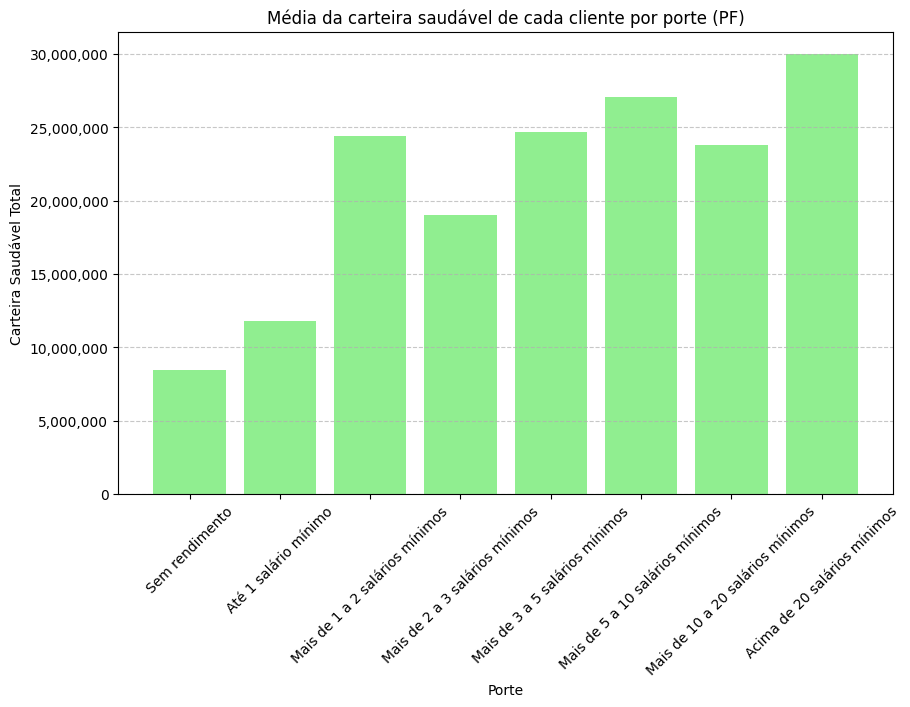

In [11]:
carteira_ativa_por_porte = df.groupby('ct_porte')['vl_carteira_saudavel'].mean()

carteira_ativa_por_porte = carteira_ativa_por_porte.reindex(ORDEM_PORTE)

carteira_ativa_por_porte = carteira_ativa_por_porte.dropna()

carteira_ativa_por_porte = carteira_ativa_por_porte.drop('Indisponível', errors='ignore')

plt.figure(figsize=(10, 6))
plt.bar(carteira_ativa_por_porte.index, carteira_ativa_por_porte.values, color='lightgreen')
plt.title(f'Média da carteira saudável de cada cliente por porte ({CLASSIFICACAO_DF})')
plt.xlabel('Porte')
plt.ylabel('Carteira Saudável Total')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

del carteira_ativa_por_porte

### Análise de Riscos por Porte dos Clientes

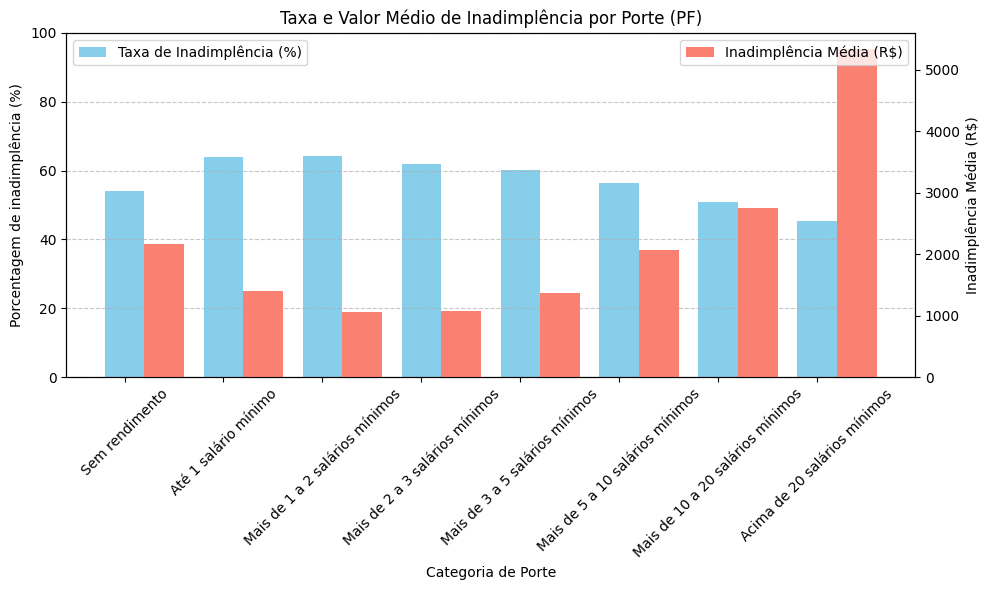

In [12]:
inadimplentes = df[df['vl_carteira_inadimplida_arrastada'] != 0.00].copy()

inadimplentes['vl_media_carteira_inadimplida_por_operacao'] = inadimplentes['vl_carteira_inadimplida_arrastada'] / inadimplentes['qt_numero_de_operacoes']


inadimplentes_por_porte = inadimplentes.groupby('ct_porte').size() / df.groupby('ct_porte').size() * 100

inadimplentes_por_porte = pd.Series(
    inadimplentes_por_porte.values,
    index=inadimplentes_por_porte.index,
    dtype='category'
).reindex(ORDEM_PORTE).dropna().drop('Indisponível', errors='ignore')


inadimplencia_media_por_cliente = inadimplentes.groupby('ct_porte')['vl_media_carteira_inadimplida_por_operacao'].mean()

inadimplencia_media_por_cliente = pd.Series(
    inadimplencia_media_por_cliente.values,
    index=inadimplencia_media_por_cliente.index,
    dtype='category'
).reindex(ORDEM_PORTE).dropna().drop('Indisponível', errors='ignore')

fig, ax1 = plt.subplots(figsize=(10, 6))

posicoes = range(len(inadimplentes_por_porte.index))
largura_barra = 0.4

ax1.bar(posicoes, inadimplentes_por_porte.values, color='skyblue', label='Taxa de Inadimplência (%)', width=largura_barra, align='center')

ax2 = ax1.twinx()

ax2.bar([p + largura_barra for p in posicoes], inadimplencia_media_por_cliente.values, color='salmon', label='Inadimplência Média (R$)', width=largura_barra, align='center')

ax1.set_title(f'Taxa e Valor Médio de Inadimplência por Porte ({CLASSIFICACAO_DF})')
ax1.set_xlabel('Categoria de Porte')
ax1.set_ylabel('Porcentagem de inadimplência (%)')
ax2.set_ylabel('Inadimplência Média (R$)')

ax1.set_xticks(posicoes)
ax1.set_xticklabels(inadimplentes_por_porte.index, rotation=45)

ax1.set_ylim(0, 100)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

del inadimplentes

### Entendendo como o risco mudou ao longo dos anos

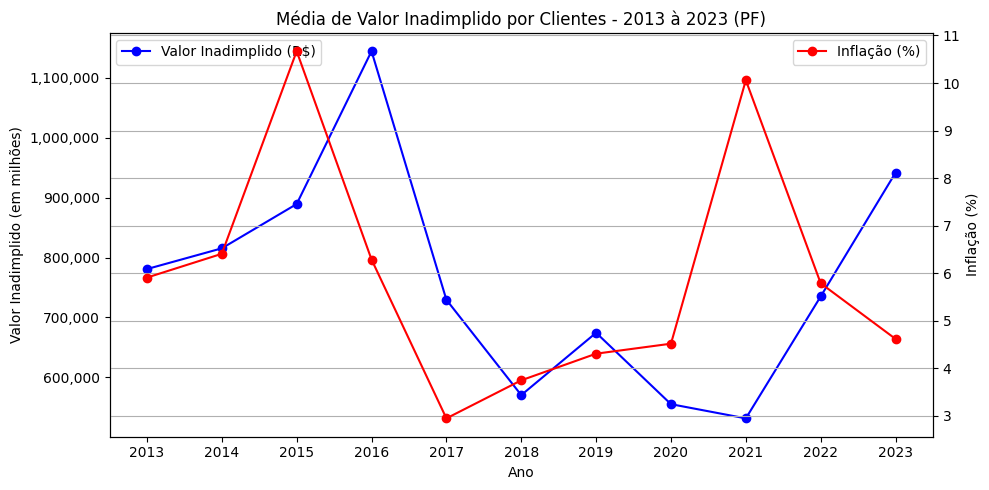

In [13]:
intervalo_definido = df.copy()
intervalo_definido['ano'] = intervalo_definido['dt_data_base'].dt.year.astype('int')

intervalo_definido = intervalo_definido[intervalo_definido['ano'].between(2013, 2023)]
inflacao_df = inflacao_df[inflacao_df['ano'].between(2013, 2023)]

resultados = intervalo_definido.groupby('ano')['vl_carteira_inadimplida_arrastada'].mean()

combined = pd.merge(resultados, inflacao_df, on='ano', how='inner')

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(combined['ano'], combined['vl_carteira_inadimplida_arrastada'], marker='o', color='blue', label='Valor Inadimplido (R$)')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Valor Inadimplido (em milhões)')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))

ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

ax2 = ax1.twinx()
ax2.plot(combined['ano'], combined['inflacao_efetiva'], marker='o', color='red', label='Inflação (%)')
ax2.set_ylabel('Inflação (%)')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.title(f'Média de Valor Inadimplido por Clientes - 2013 à 2023 ({CLASSIFICACAO_DF})')
plt.grid(True)
plt.xticks(combined['ano'])

plt.tight_layout()
plt.show()

## Decisões Estratégicas de Negócio

### Distribuição de Clientes por Estado

In [14]:
pib_df.sort_values(by='pib', ascending=False, inplace=True)

In [15]:
pib_df['porcentagem'] = pib_df['pib'] / pib_df['pib'].sum() * 100

In [132]:
cmap = plt.cm.Reds

norm = mpl.colors.LogNorm(vmin=pib_df['porcentagem'].min() - 1, vmax=pib_df['porcentagem'].max() + 20)
rgba_colors = cmap(norm(pib_df['porcentagem']))
hex_colors = [mpl.colors.to_hex(c) for c in rgba_colors]

pib_df['color'] = hex_colors

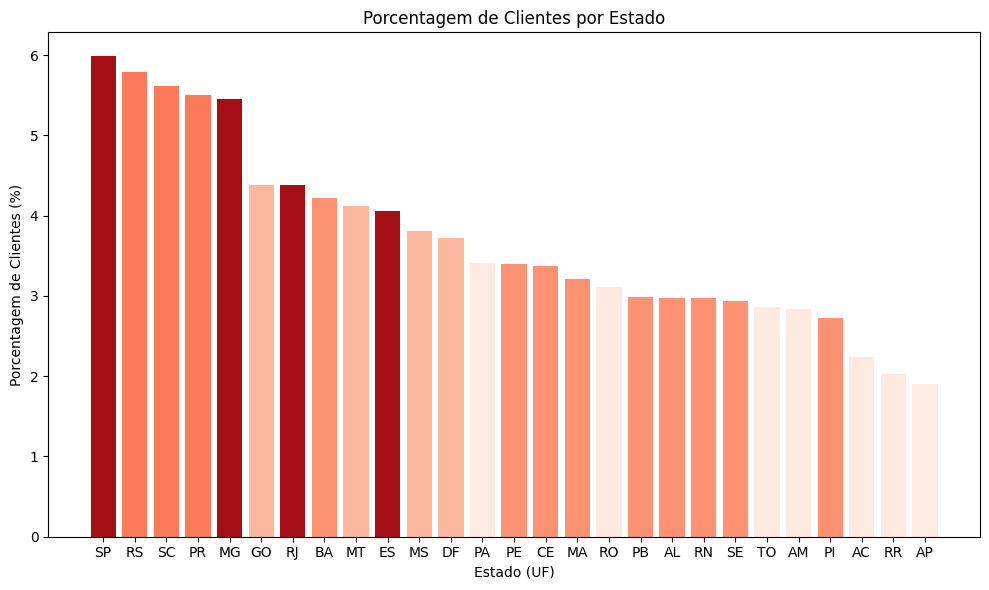

In [133]:
import matplotlib.pyplot as plt

state_counts = df['ct_uf'].value_counts()

state_percentage = pd.DataFrame({
    'state': state_counts.index,
    'percentage': (state_counts / state_counts.sum()) * 100
}).reset_index(drop=True)

state_percentage['region'] = state_percentage['state'].map(estados_df.set_index('estado')['regiao'])
state_percentage['color'] = state_percentage['region'].map(pib_df.set_index('estado')['color'])

state_percentage = state_percentage.sort_values('percentage', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(state_percentage['state'], state_percentage['percentage'], color=state_percentage['color'])
plt.xlabel('Estado (UF)')
plt.ylabel('Porcentagem de Clientes (%)')
plt.title('Porcentagem de Clientes por Estado')

plt.tight_layout()
plt.show()

## A definir

In [19]:
anos = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

df_filtrado = df[df['nu_numero_de_operacoes'] > 15]

df_filtrado = df[df['dt_data_base'] > pd.to_datetime('2013-01-01')]
df_filtrado = df_filtrado[df_filtrado['dt_data_base'] < pd.to_datetime('2023-12-01')]

df_filtrado['Ano'] = df_filtrado['dt_data_base'].dt.year

q1 = df_filtrado['nu_numero_de_operacoes'].quantile(0.25)
q3 = df_filtrado['nu_numero_de_operacoes'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

df_sem_outliers = df_filtrado[(df_filtrado['nu_numero_de_operacoes'] >= limite_inferior) & (df_filtrado['nu_numero_de_operacoes'] <= limite_superior)]

resultados = []

for ano in anos:
    df_ano_especifico = df_sem_outliers[df_sem_outliers['Ano'] == int(ano)]  
    valor_acumulado = df_ano_especifico['nu_numero_de_operacoes'].sum()
    resultados.append(valor_acumulado)

def millions(x, pos):
    return f'{x * 1e-6:.1f}'  

plt.figure(figsize=(12, 6))
bars = plt.bar(anos, resultados, color='skyblue')

media = np.mean(resultados)
plt.axhline(y=media, color='red', linestyle='--', label='Média: {:.1f} milhões'.format(media * 1e-6))

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(millions))

plt.xlabel('Ano')
plt.ylabel('Operações acumuladas')
plt.title('Variação de Valores Acumulados por Ano')

plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout() 
plt.show()

KeyError: 'nu_numero_de_operacoes'

In [ ]:
df_grouped = df.groupby('ct_porte')['nu_numero_de_operacoes'].sum().reset_index()

df_grouped = df_grouped[df_grouped['nu_numero_de_operacoes'] > 0]

plt.figure(figsize=(10, 6))
plt.bar(df_grouped['ct_porte'], df_grouped['nu_numero_de_operacoes'], color='blue')
plt.title('Número de operações por porte', fontsize=14)
plt.xlabel('Porte', fontsize=12)
plt.ylabel('Número de operações', fontsize=12)

plt.xticks(rotation=60)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

In [ ]:
df_grouped = df.groupby('ct_ocupacao')['nu_numero_de_operacoes'].sum().reset_index()

df_grouped = df_grouped.sort_values(by='nu_numero_de_operacoes', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(df_grouped['ct_ocupacao'], df_grouped['nu_numero_de_operacoes'], color='blue')

plt.title('Número de operações por ocupação', fontsize=14)
plt.xlabel('Ocupação', fontsize=12)
plt.ylabel('Número de operações', fontsize=12)

plt.xticks(rotation=60)

plt.tight_layout()
plt.show()